In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import optimization_SPDC as opt
import optimization_SPDC_gaussain_pump as gauss_opt
import jax.scipy.optimize as jax_opt
import get_initialization_cond as init

key = jax.random.PRNGKey(0)
np.random.seed(0)

# Initialize the values

In [2]:
# Setting all hyper parameters that can influence the results of backprop
Np = 0.02
N = 701
wi = -10
wf = 10
vp = 0.1
l = 1

In [3]:
# Setting up all constant, vectors and matrices to be used from the hyper parameters
x = np.linspace(wi, wf, N)
low_alpha = 0.010531683986844237
w = np.linspace(2*wi, 2*wf, 2*N)
alpha, G, H = init.get_constants(vp, l, wi, wf, Np, N = N)

In [69]:
y_K = 1
# Get results for different gain values
y_N =10#jnp.array([0.032, 1, 2, 3, 10])

# Backprop with BFGS through every element of pump for every gain value

In [5]:
# Initialization with gaussian
# if the initialization has values that diverge too much, possibility of optimal function to be tilted to extremities
a = []
a.append(0.1*scipy.special.hermite(0)(w)*jnp.exp(-(w**2)/2))#(0.2/jnp.cosh((jnp.linspace(2*wi, 2*wf, 2*N))**2))
a.append(0.03*scipy.special.hermite(0)(w)*jnp.exp(-(w**2)/2))#(1/jnp.cosh((jnp.linspace(2*wi, 2*wf, 2*N))**2))
a = jnp.array(a)
a = jnp.reshape(a, 2*len(a[0]))
# List of complex arrays
optimized_pump = []
for i in range(len(y_N)):
    optimized = jax_opt.minimize(opt.get_total_loss, a, args = (N, alpha, G, H, l, y_N[i], y_K), method = "BFGS")
    optimized_a = optimized.x
    optimized_pump.append(opt.get_complex_array(optimized_a))
    print("Valeur de i: ", i)

Exception ignored in: <generator object iter_fields at 0x000001C8FAA72580>
Traceback (most recent call last):
  File "C:\Users\super\Anaconda3\lib\ast.py", line 252, in iter_fields
    except AttributeError:
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Initialize with flat function
a = 0.1*jax.random.uniform(key, shape = (4*N,))
optimized_pump = []
for i in range(len(y_N)):
    optimized = jax_opt.minimize(get_total_loss, a, args = (N, alpha, G, H, l, y_N[i], y_K), method = "BFGS")
    optimized_a = optimized.x
    optimized_pump.append(opt.get_complex_array(optimized_a))
    print("Value de i: ", i)

# BFGS every element for a single gain value

In [12]:
# Initialize with flat function
a = 0.1*jnp.ones(4*N)
const_optimized = jax_opt.minimize(get_total_loss, a, args = (N, alpha, G, H, l, 1, y_K), method = "BFGS", options=dict(maxiter = 10e7, gtol = 10e-7))
const_optimized_pump = opt.get_complex_array(const_optimized.x)

In [70]:
# Initialize with x times gauss
a = []
a.append(0.05*scipy.special.hermite(0)(w)*jnp.exp(-(w**2)/2))#(0.2/jnp.cosh((jnp.linspace(2*wi, 2*wf, 2*N))**2))
a.append(0.025*scipy.special.hermite(0)(w)*jnp.exp(-(w**2)/2))#(1/jnp.cosh((jnp.linspace(2*wi, 2*wf, 2*N))**2))
a = jnp.array(a)
a = jnp.reshape(a, 2*len(a[0]))
optimized = jax_opt.minimize(opt.get_total_loss, a, args = (N, alpha, G, H, l, y_N, y_K), method = "BFGS", options=dict(maxiter = 10e7, gtol = 10e-7))
optimized_pump = opt.get_complex_array(optimized.x)

(DeviceArray(0.03598321, dtype=float32), DeviceArray(2.2946723, dtype=float32))

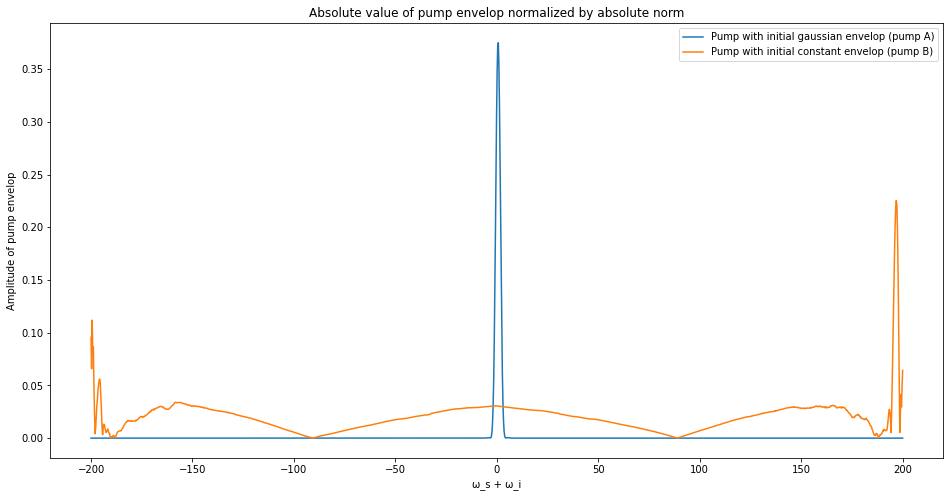

In [16]:
# Show results
plt.figure(figsize = (16,8))
plt.title("Absolute value of pump envelop normalized by absolute norm")
plt.xlabel("ω_s + ω_i")
plt.ylabel("Amplitude of pump envelop")
plt.plot(w,jnp.abs(optimized_pump/(jnp.linalg.norm(optimized_pump))), label = "Pump with initial gaussian envelop (pump A)")
plt.plot(w,jnp.abs(const_optimized_pump/(jnp.linalg.norm(const_optimized_pump))), label = "Pump with initial constant envelop (pump B)")
plt.legend()
plt.savefig("diff_init_value.pdf")
opt.get_observables(a,N, alpha, G, H, l)

# Initialize parameter values for gaussian

In [62]:
theta = jnp.array([1, 1., jnp.pi*2/7])
optimized_gauss = jax_opt.minimize(gauss_opt.get_total_loss, theta, args = (w, alpha, G, H, l, y_N, y_K), method = "BFGS")

In [7]:
theta = jnp.array([0.5, 1., jnp.pi*2/7])
optimized_gauss_pumps = []
for i in range(len(y_N)):
    optimized = jax_opt.minimize(get_total_loss, a, args = (N, alpha, G, H, l, y_N[i], y_K), method = "BFGS")
    optimized_gauss_pumps.append(jax_opt.minimize(get_total_loss_gaussian, theta, args = (w, alpha, G, H, l, y_N[i], y_K), method = "BFGS"))
a = opt.get_complex_array(a)

In [13]:
# Save gaussian array and optimal array
np.save("optimized_pump_first_hermite_low_initialization", np.array(optimized_pump))

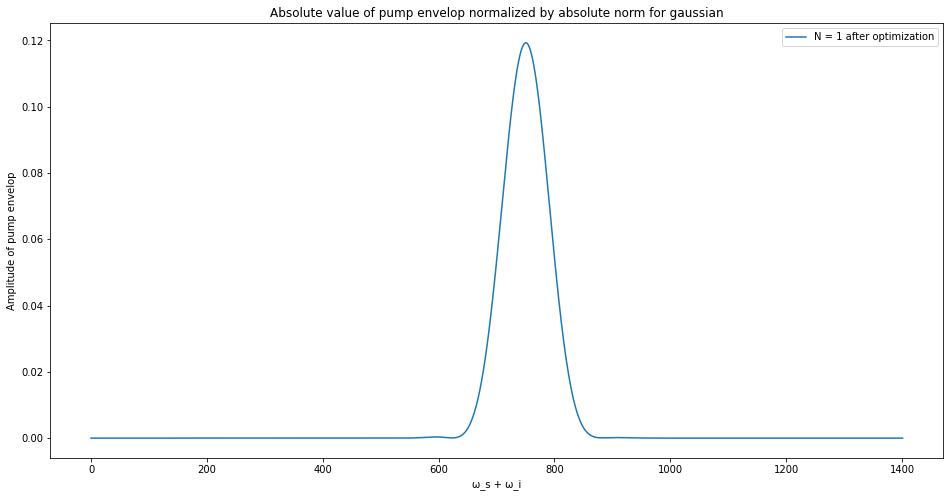

In [26]:
# plot the pumps for different values of N
plt.figure(figsize = (16,8))
plt.title("Absolute value of pump envelop normalized by absolute norm for gaussian")
plt.xlabel("ω_s + ω_i")
plt.ylabel("Amplitude of pump envelop")
plt.plot(jnp.abs(optimized_pump/(jnp.linalg.norm(optimized_pump))), label = "N = 1 after optimization")
#plt.plot(jnp.abs(optimized_pump[1]/(jnp.linalg.norm(optimized_pump[1]))), label = "N = 2 after optimization")
#plt.plot(jnp.abs(optimized_pump[2]/(jnp.linalg.norm(optimized_pump[2]))), label = "N = 3 after optimization")
#plt.plot(jnp.abs(optimized_pump[3]/(jnp.linalg.norm(optimized_pump[3]))), label = "N = 4 after optimization")
#plt.plot(jnp.abs(optimized_pump[4]/(jnp.linalg.norm(optimized_pump[4]))), label = "N = 5 after optimization")
plt.legend()

In [78]:
len(optimized.x)

2804

# Show the results

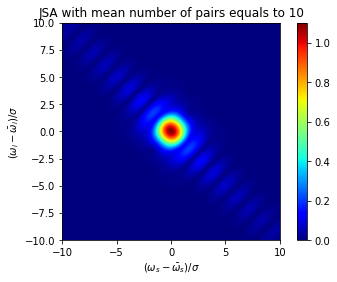

Optimized gauss: (DeviceArray(1.0067255, dtype=float32), DeviceArray(1.1430694, dtype=float32))
Optimized pump:  (DeviceArray(10.000116, dtype=float32), DeviceArray(1.0399042, dtype=float32))


In [83]:
JSA = opt.get_JSA(w, optimized.x, N, alpha, G, H, l)
fig, ax = plt.subplots()
im = ax.imshow(JSA, cmap="jet", origin="lower",extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_title("JSA with mean number of pairs equals to 10")
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
plt.colorbar(im, orientation="vertical")
plt.savefig("plots/optimized_gauss_10_N.pdf")
plt.savefig("plots/optimized_gauss_10_N.jpg")
plt.show()
print("Optimized gauss:", gauss_opt.get_observable(optimized_gauss.x, w, alpha, G, H, l))
print("Optimized pump: ", opt.get_observables(optimized.x, N, alpha, G, H, l))

In [18]:
# get fidelity between optimal pump and optimal gaussian
normalized_gaussian_pump = optimized_gauss_pump/jnp.linalg.norm(optimized_gauss_pump)
normalized_optimal_pump = complex_a/ jnp.linalg.norm(complex_a)
normalized_a = a/jnp.linalg.norm(a)
print("Fidelity: ", jnp.abs(jnp.vdot(normalized_gaussian_pump, normalized_optimal_pump)))

# Read saved arrays and plot observations accordingly

In [8]:
optimized_pump = np.load("results/optimized_pump_real_and_imag.npy")
#optimized_thetas = np.load("results/theta_gaussian_comparison_diff_N.npy")
complex_optimized_pump = []
complex_opt_gauss = []
K_gauss = []
K = []
for i in range(len(optimized_pump)):
    complex_optimized_pump.append(opt.get_complex_array(optimized_pump[i]))
    #complex_opt_gauss.append(optimized_thetas[i][0]*np.exp(-((optimized_thetas[i][1])*w)**2)*np.exp(1j*optimized_thetas[i][2]))
    K.append(opt.get_observables(optimized_pump[i], N, alpha, G, H, l)[1])
    #K_gauss.append(gauss_opt.get_observable(optimized_thetas[i], w, alpha, G, H, l)[1])

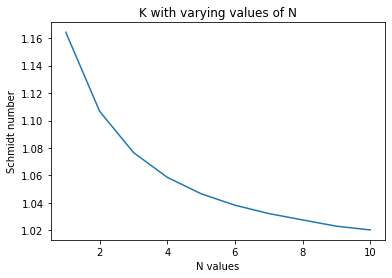

In [10]:
plt.title("K with varying values of N")
plt.xlabel("N values")
plt.ylabel("Schmidt number")
plt.plot(np.linspace(1,10,10),K)
plt.savefig("plots/K_N_pump_opt.pdf")

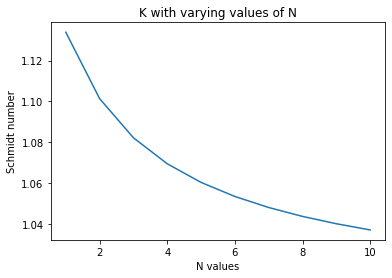

In [12]:
plt.title("K with varying values of N")
plt.xlabel("N values")
plt.ylabel("Schmidt number")
plt.plot(np.linspace(1,10,10),K_gauss)

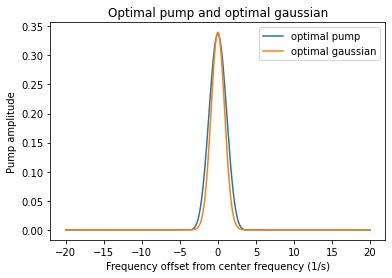

In [68]:
len(optimized_pump)
opt_theta = optimized_gauss.x
complex_gauss = opt_theta[0]*jnp.exp(-(w**2)*opt_theta[1])*jnp.exp(1j*opt_theta[2])
plt.title("Optimal pump and optimal gaussian")
plt.xlabel("Frequency offset from center frequency (1/s)")
plt.ylabel("Pump amplitude")
plt.plot(w, np.abs(optimized_pump), label = "optimal pump")
plt.plot(w, np.abs(complex_gauss), label = "optimal gaussian")
plt.legend()
plt.savefig("plots/likeliness_N_1_gauss_optimized.pdf")
plt.savefig("plots/likeliness_N_1_gauss_optimized.jpg")

In [66]:
jnp.abs(optimized_pump/jnp.linalg.norm(optimized_pump)@complex_gauss/jnp.linalg.norm(complex_gauss))

DeviceArray(0.98651826, dtype=float32)

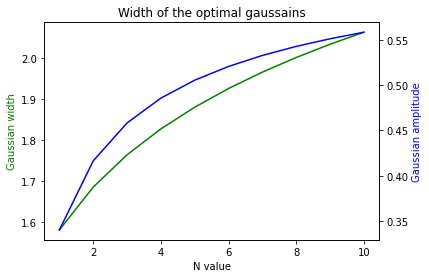

In [14]:
bandwidth = (optimized_thetas.T)[1]
domain = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_title("Width of the optimal gaussains")
ax1.set_xlabel("N value")
ax1.set_ylabel("Gaussian width", color = "g")
ax2.set_ylabel("Gaussian amplitude", color = "b")
ax1.plot(domain, 1/bandwidth, color = "g")
ax2.plot(domain, amplitude, color = "b")

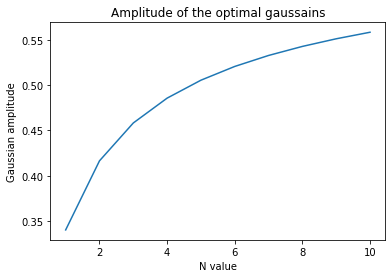

In [6]:
amplitude = (optimized_thetas.T)[0]
plt.title("Amplitude of the optimal gaussains")
plt.xlabel("N value")
plt.ylabel("Gaussian amplitude")
plt.plot(domain, amplitude)